# Demonstration of SUSY information loss

A hopefully quick demonstration of the limits of the SUSY analysis method for assess synchrony between pairs of signals, both on what kinds of information this method can reliably evaluate and more specifically for concurrent psychophysiology measurements from musicians and people attending to music. Papers using SUSY on music audience measurements: http://dx.doi.org/10.1037/aca0000431, https://doi.org/10.1038/s41598-023-41960-2. Relevant methods paper: https://doi.org/10.3390/e23111385.

SUSY is an analysis method that should be considered in two parts:

    1. A measure of similarity: the average Z tranformed cross-correlation (pearson) between pairs of signal segments, with a parameter for the segment length (often 30 seconds) and the cross-correlation range (often 10 seconds, i.e., +/- 5 s). *(Note: A variant of SUSY uses both the non-absolute and absolute average Z transformed cross-correlation, however the examples used for music related papers only make use of the non-absolute version so this will focus only on the average non-rectified Fisher's Z transformed cross-correlations.)*
    
    2. A test of similarity between the pair of signals against a data-derived surrogate: comparison of the similarity measure distributions for REAL segment pairs (measured at the same time) and SUPPLEMENTARY segment pairs. Means of the distributions are evaluated with a t-test (one-tailed) and some measure of effect size.
    
Let me first say, I don't have a problem with the second part, this surrogate comparison. It has some limitations, but the principle of using the measurements to define the null is sound and the same strategy I use in the local coordination test of Activity Analysis (https://doi.org/10.1525/mp.2018.35.3.253, https://github.com/finn42/ActivityAnalysis_PythonConversion/). I personally wouldn't call a significant result from part 2 to be a demonstration of synchrony. Its meaning should be tempered by what information is available in the signals, the actual relationship between the signals, and what is captured by the measure in the first part. Still, on sufficiently long signals, it's a good choice for assessing shared information at the segmentation rate between signals with temporal qualities that are hard to describe analytically.  

The main issue is with the first part, the average Z-transformed cross-correlation. This measure of similarity is being treated like a signal-agnostic tool for assessing shared information between signals when that is very far from what is going on, mathematically. Simply put, the average cross-correlation cannot reliably assess synchrony between oscillatory signals with periods shorter than the interval of cross-correlation. Over a range of 10 seconds, phasic relationships between the signals in frequencies above 0.1 Hz are filtered out. (At the other end, 30 s also acts as a limit for information carried at slower rates, although those don't come up as often in music-related measurements.) Considering that a lot of physiological and gestural signals have information at higher rates than 0.1 Hz, and how these can be aligned *in phase* with precision closer to 0.1 s in musical context, this measure of similarity is likely missing a lot of information relevant to the synchrony between bodies in the context of music.

If that argument makes sense to you: Congrats and please use your basic signal processing knowledge for good causes. If that doesn't, please continue reading as I demonstate how this measure actually erases information that would otherwise be accepted as evidence of synchronisation between pairs of signals.

First I'll show how SUSY behaves on some toy signals that should be counted as *synchronised*, then on some real respiration measurements from a human listening to music. On the respiration measurements, I'll demonstrate how the cross-correlation range determines whether phasic relationships are detectable in these naturally oscillatory signals. Last is a little discussion of how the technique could be amended to suit music researchers priorities and what other common physiological signals should not be subjected to the default SUSY treatment, particularly at the default paramters.

Note: This Entropy paper (https://doi.org/10.3390/e23111385) also applies the SUSY analysis pipeline to synthetic or toy data. The tests performed were specifically to demonstrate how the method doesn't produce false positives on synthetic data with different characteristics (including a dataset of sine waves). It is true that the method would not falsely identify synchrony between unrelated signals with high autocorrelation. However, the paper does not address how this method is in danger of producing FALSE NEGATIVES on signals that are oscillatory. It is the conditions for false negatives that are explored below, along with the interpretation of positive results on signals with oscillatory components.

# Demo set up

Python libraries for generating and plotting demonstrations. My implementation of SUSY and some bespoke plotting functions can be found in the accompanying file susy.py. The respiration data in the ./data/ folder is taken from the repeated response experiments that were part of my dissertation research, also published on Figshare https://figshare.com/articles/dataset/Repeated_Responses_Datasets/5632210.

In [1]:
import sys
import os
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import warnings

from scipy.signal import butter, filtfilt, argrelextrema
from scipy.interpolate import interp1d

The following pair of cells allows use of the definitions in the accompanying susy.py file. This includes specialised ploting functions and my python implementations of SUSY.

In [5]:
%load_ext autoreload
%autoreload 1
%aimport susy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%reload_ext autoreload

In [7]:
warnings.filterwarnings('ignore')

# Toy signal pair examples

The simplest demonstration of what information is captured or lost by the average z-transformed cross-correlation is to show what happens with identical signal components with dominant frequencies above and below the cutoff defined by the cross-correlation range. Identitical signals are trivially synchronous, and should be easily detected by any measure of similarity. Because the Fisher's Z transformation can't handle perfect correlations, a low amplitude layer of white noise has been added to each synthetic signal, however, by construction, the shared information between these toy signal pairings is still very strong. 

For all the synthetic signal pairs in this section, they are constructed with a sample rate of 10 Hz, duration of 301 seconds. The SUSY analysis then evaluates 10 segments of 30 s each with a cross-correlation range of 10 s (+/- 5 s). 

With this cross-correlation range, the threshold for low and high frequences is 0.1 Hz (1/10 s), and the examples below show how differently this parameter treats signals with high and low frequency componets. Specifically tested are:

    1. Signals with identical low frequency components 
    2. Signals with identical low frequency components and offset by 4 s
    3. Signals with identical high frequency components at 0.2 Hz (parameter interactions)
    4. Signals with identical high frequency components at 0.13 Hz (closer to cutoff)
    5. Signals with identical high frequency components that drift 0.13-0.2 Hz
    6. Signals with low and high frequency components
    
The following plots show the signals being compared, the construction of the Fisher's Z transformed cross-correlation average on example segments, the resultant values on the Real and Surrogate segments of the pair of signals, and the results of a one-tailed unpaired t-test between these two sets. 

For convenience, and space, the similarity measure is refered to as ZXCORR in figures and code.

In [76]:
samplerate = 10 # sample rate on the signal being evaluated
dur = 301 # seconds or 6 minutes, a normal duration for a piece of concert music
times = np.arange(dur * samplerate)/samplerate

seg_size = 30 # seconds
segment_boundaries = np.arange(0,dur+1,seg_size)
n = len(segment_boundaries)-1

xcorr_range = 5 # +/- 5 seconds 
maxlag = xcorr_range*samplerate

## Signals with identical low frequency components
When the signal information is changing more slowly than the cross-correlation range, SUSY can reliably detect the shared information.

Pearson r(A,B) = 0.95


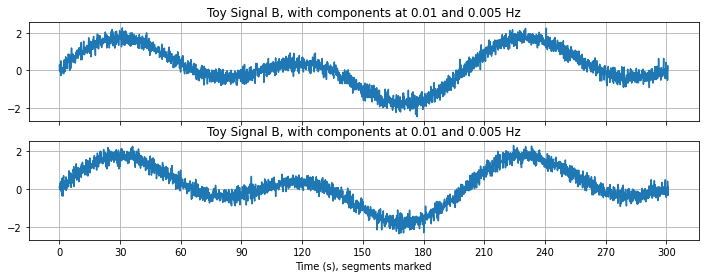

In [10]:
# generate toy signals
freq1 = 0.01 # Hz, rate of sin wave generated 
freq2 = 0.005 # Hz, even slower second component
Common_signal = np.sin(((2*np.pi)*freq1)*times)+np.sin(((2*np.pi)*freq2)*times)
sig_A = Common_signal + susy.white_noise(0.1, samplerate, len(times))
sig_B = Common_signal + susy.white_noise(0.1, samplerate, len(times))
print('Pearson r(A,B) = ' + str(sp.stats.pearsonr(sig_A, sig_B).statistic.round(2)))

# plot signals and segmentation
fig, axs = plt.subplots(2,1, sharex='all',sharey='all',figsize=(12,4))
axs[0].plot(times,sig_A)
axs[0].set_title('Toy Signal B, with components at ' + str(freq1) + ' and '+ str(freq2) +' Hz')
axs[1].plot(times,sig_B)
axs[1].set_title('Toy Signal B, with components at ' + str(freq1) + ' and '+ str(freq2) +' Hz')
axs[1].set_xlabel('Time (s), segments marked')
axs[1].set_xticks(segment_boundaries)
axs[0].grid()
axs[1].grid()
plt.savefig('./plots/Toy_slow_pair.png', bbox_inches = 'tight',dpi = 100)
plt.show()

These signals are not identical because of the layer of white noise, but they share the exact same slow trajectory and correlate strongly over their full duration (r = 0.95).

Rather than look at the whole signals with one alignment, SUSY looks at correlations over a range of lags on sub-sections of the full signal length, here cut into 30 s seconds

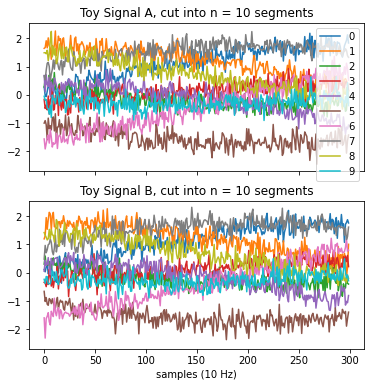

In [11]:
# cut the two signals into segments 
sig_A_segments = {}
sig_B_segments = {}
for i in range(n):
    seg_index = np.arange(segment_boundaries[i]*samplerate,segment_boundaries[i+1]*samplerate)
    sig_A_segments[i] = sig_A[seg_index]
    sig_B_segments[i] = sig_B[seg_index]
    
# plot segments
fig, axs = plt.subplots(2,1, sharex='all',sharey='all',figsize=(6,6))
for i in range(n):
    axs[0].plot(sig_A_segments[i],label=i)
    axs[1].plot(sig_B_segments[i],label=i)
axs[0].set_title('Toy Signal A, cut into n = '+str(n)+' segments')
axs[1].set_title('Toy Signal B, cut into n = '+str(n)+' segments')
axs[1].set_xlabel('samples ('+str(samplerate)+' Hz)')
axs[0].legend()
plt.show()

As these signals are basically the same, the two segments of A and of B look very similar. 

Now to show how the measure of similarity, the average Fisher's Z transformation of the Pearson correlation over lags from - 5 s to + 5 s (or -50 samples to 50 samples on this sample rate of 10 Hz). The first pair of plots show segments that match, being the first 30 seconds of both A and B. The second pair of plots shows the results for segments that will count towards the supplementary pairs. 

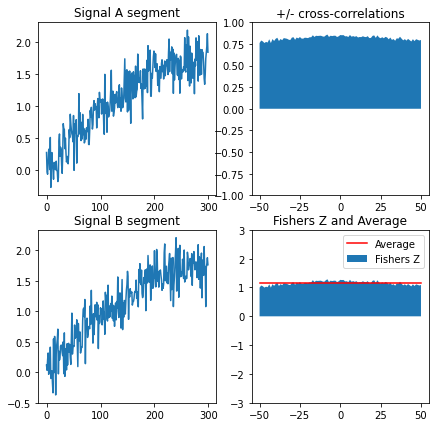

ZXCORR mean for matching segments A0 and B0: 1.154


In [16]:
segment_i = 0 # demonstrate on a signal segment 
segment_j = segment_i # matching segments
zx = susy.plot_zxcorr_pairs(sig_A_segments[segment_i],sig_B_segments[segment_j],maxlag)
print('ZXCORR mean for matching segments A0 and B0: '+ str(zx.round(3)))

On the left are the segments being compared, from signal A and signal B. On the top right is plotted the cross-correlation values between these signals with lags of -50 samples to 50 samples (-5 to 5 seconds). On the bottom right is the same cross-correlation values transformed by Fisher's Z and the average value across lags marked in red. It is the height of the red line, here at 1.15, that is taken to represent the similarity between these two segments. The cross-correlation values and Fisher's Z are highest in the middle, around 0, because these signals are in fact perfectly synchronous under their respective layers of white noise.

In theory, this average value will be higher for pairs of segments that actually occurred at the same time (in this case same 30s segment), than for pairs in the surrogate combinations.

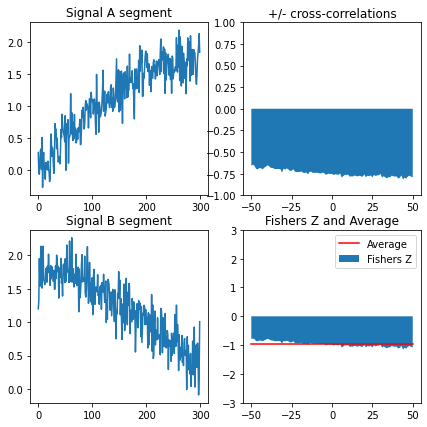

ZXCORR mean for non-matching segments A0 and B1: -0.971


In [17]:
# demo cross correlation between segments that do not match
segment_i = 0
segment_j = 1

zx = susy.plot_zxcorr_pairs(sig_A_segments[segment_i],sig_B_segments[segment_j],maxlag)
print('ZXCORR mean for non-matching segments A0 and B1: '+ str(zx.round(3)))

And here, the unmatched pair indeed have much lower similarity. Negative values indication opposite trajectories of change, and while negative correlations can be suggestive of shared information (or anti-phase sync), we are evaluting only the non-absolute SUSY metric.

SUSY tests the distribution of similarity measure values between the real pairs (red) and the supplementary pairs (blue), as shown in the box plots below:

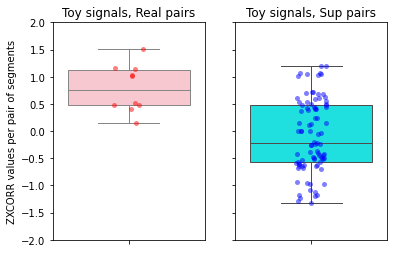

In [18]:
seg_sims = susy.zxcorr_sims(sig_A_segments,sig_B_segments,maxlag)

# show the difference in zxcorr similarity values between real 
# and "supplimentary" signal segment pairs
fig, axs = plt.subplots(1,2,sharey = 'all',figsize=(6,4))
sns.boxplot(y=seg_sims['Real'],color = 'pink', ax=axs[0])
sns.stripplot(y=seg_sims['Real'],alpha=0.5,color = 'red', ax=axs[0])
axs[0].set_title('Toy signals, Real pairs')
sns.boxplot(y=seg_sims['Sup'], color = 'aqua', ax=axs[1])
sns.stripplot(y=seg_sims['Sup'],alpha=0.5,color = 'blue', ax=axs[1])
axs[1].set_title('Toy signals, Sup pairs')
axs[0].set_ylabel('ZXCORR values per pair of segments')
axs[0].set_ylim([-2,2])
plt.show()

SUSY successfully captures the shared information between these extremely related signals with components that change slowly (rates <0.1 Hz). Even though some of the surrogate pairs reach values similar to the real segment pairs, the means of these two distributions are very different, with Cohen's d above 1.3 (effect size).

In [20]:
ttest = pg.ttest(seg_sims['Real'], seg_sims['Sup'],alternative='greater').round(2)
print(ttest)

           T    dof alternative  p-val        CI95%  cohen-d       BF10  power
T-test  5.58  14.18     greater    0.0  [0.59, inf]     1.33  8.697e+04   0.99


## Signals with identical low frequency components and offset by 4 s

SUSY's test resuls are similar for these signals when they are offset by some amount smaller than the cross correlation range. 

Signals with a 4-second delay between them would not be considered "synchronous" in a musical context, but SUSY is barely affected.

Pearson r(A,B) = 0.93


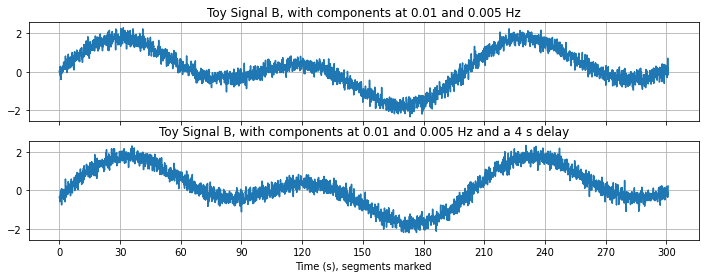

In [77]:
# generate toy signals
freq1 = 0.01 # Hz, rate of sin wave generated 
freq2 = 0.005 # Hz, even slower second component
times_offset = 4 # seconds

sig_A = np.sin(((2*np.pi)*freq1)*times)+np.sin(((2*np.pi)*freq2)*times) + susy.white_noise(0.1, samplerate, len(times))
sig_B = np.sin(((2*np.pi)*freq1)*(times-times_offset))+np.sin(((2*np.pi)*freq2)*(times-times_offset)) + susy.white_noise(0.1, samplerate, len(times))
print('Pearson r(A,B) = ' + str(sp.stats.pearsonr(sig_A, sig_B).statistic.round(2)))

sig_A_segments = susy.sig_seg(sig_A,seg_size*samplerate)
sig_B_segments = susy.sig_seg(sig_B,seg_size*samplerate)
n = len(sig_A_segments)

# plot signals and segmentation
fig, axs = plt.subplots(2,1, sharex='all',sharey='all',figsize=(12,4))
axs[0].plot(times,sig_A)
axs[0].set_title('Toy Signal B, with components at ' + str(freq1) + ' and '+ str(freq2) +' Hz')
axs[1].plot(times,sig_B)
axs[1].set_title('Toy Signal B, with components at ' + str(freq1) + ' and '+ str(freq2) +' Hz and a 4 s delay')
axs[1].set_xlabel('Time (s), segments marked')
axs[1].set_xticks(segment_boundaries)
axs[0].grid()
axs[1].grid()
plt.savefig('./plots/Toy_slow_pair_4soff.png', bbox_inches = 'tight',dpi = 100)
plt.show()

The oscillatory components on these signals are so slow that a 4 second offset also does not substantially hamper the correlation on their full length (r=-.93 instead of 0.95).

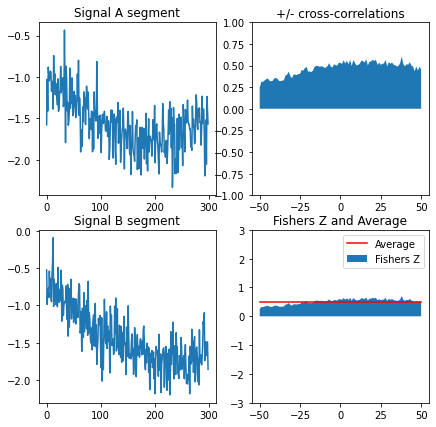

ZXCORR mean for matching segments A5 and B5: 0.511


In [83]:
segment_i = 5 # demonstrate on a signal segment 
segment_j = segment_i # matching segments
zx = susy.plot_zxcorr_pairs(sig_A_segments[segment_i],sig_B_segments[segment_j],maxlag)
print('ZXCORR mean for matching segments A5 and B5: '+ str(zx.round(3)))

Above is the example of the cross-correlation results on the matching signals at segment 5 (starting at 150 s), a real segment pair where the 4 second offset has a noticeable effect on the cross correlation lags. There are higher values to the right in the right-most plots as the cross-correlation lags compensate the delay between A and B.

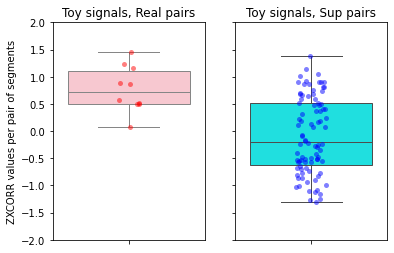

In [22]:
seg_sims = susy.zxcorr_sims(sig_A_segments,sig_B_segments,maxlag)

# show the difference in zxcorr similarity values between real 
# and "supplementary" signal segment pairs (Comment: CONSIDER USING CONSISTENT LANGUAGE AND CALLING THIS SURROGATE)
fig, axs = plt.subplots(1,2,sharey = 'all',figsize=(6,4))
sns.boxplot(y=seg_sims['Real'],color = 'pink', ax=axs[0])
sns.stripplot(y=seg_sims['Real'],alpha=0.5,color = 'red', ax=axs[0])
axs[0].set_title('Toy signals, Real pairs')
sns.boxplot(y=seg_sims['Sup'], color = 'aqua', ax=axs[1])
sns.stripplot(y=seg_sims['Sup'],alpha=0.5,color = 'blue', ax=axs[1])
axs[1].set_title('Toy signals, Sup pairs')
axs[0].set_ylabel('ZXCORR values per pair of segments')
axs[0].set_ylim([-2,2])
plt.show()

In [23]:
ttest = pg.ttest(seg_sims['Real'], seg_sims['Sup'],alternative='greater').round(2)
print(ttest)

           T    dof alternative  p-val        CI95%  cohen-d       BF10  power
T-test  5.63  15.22     greater    0.0  [0.59, inf]     1.26  1.062e+05   0.98


SUSY tolerates such a substantial offset without major penalty, here finding a Cohen's d of over 1.25 for signal components that reached 1.36 when perfectly aligned. 

This tolerance for big delays between signal information is by design, making the measure of shared information particularly suitable for signals that can't be expected to change simultaneously. 

## Signals with identical high frequency components at 0.2 Hz

The kind of information captured by the average cross-correlation depends on how the measure parameters interact with signal properties. When the signals being compared are changing relatively quickly, the cross-correlation will also alternate between positive and negative values, with the resultant average value being much lower and vulnerable to noise. 

To demonstrate this, we go over a few different toy signals, still with some identical oscillatory component plus noise. First is a pair of signals with 0.2 Hz oscillatory components, a rate that is fairly slow, cycling every 5 s, but not far from common musical and physiological rates of change.

Pearson r(A,B) = 0.91


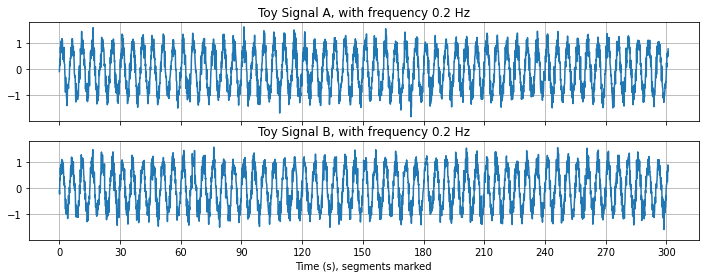

In [24]:
# generate toy signals
tag = 'Toy_0p2hz'
freq = 0.2 # Hz, rate of sin wave generated 

Common_signal = np.sin(((2*np.pi)*freq)*times)
sig_A = Common_signal + susy.white_noise(0.1, samplerate, len(times))
sig_B = Common_signal + susy.white_noise(0.1, samplerate, len(times))
print('Pearson r(A,B) = ' + str(sp.stats.pearsonr(sig_A, sig_B).statistic.round(2)))

# cut them into segments
sig_A_segments = susy.sig_seg(sig_A,seg_size*samplerate)
sig_B_segments = susy.sig_seg(sig_B,seg_size*samplerate)
n = len(sig_A_segments)

# plot signals and segmentation
fig, axs = plt.subplots(2,1, sharex='all',sharey='all',figsize=(12,4))
axs[0].plot(times,sig_A)
axs[0].set_title('Toy Signal A, with frequency ' + str(freq) + ' Hz')
axs[1].plot(times,sig_B)
axs[1].set_title('Toy Signal B, with frequency ' + str(freq) + ' Hz')
axs[1].set_xlabel('Time (s), segments marked')
axs[1].set_xticks(segment_boundaries)
axs[0].grid()
axs[1].grid()
plt.savefig('./plots/'+tag+'_pair.png', bbox_inches = 'tight',dpi = 100)
plt.show()

Here again, a correlation over their full length in their original alignment is extremely high (r = 0.91).

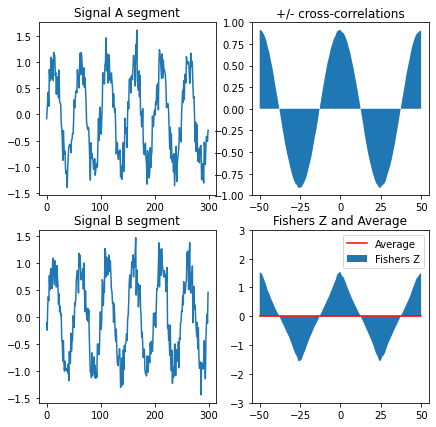

ZXCORR mean for matching segments A0 and B0: 0.018


In [25]:
# demo cross correlation between segments that match
segment_i = 0 # demonstrate on a signal segment 
segment_j = segment_i # matching segments

zx = susy.plot_zxcorr_pairs(sig_A_segments[segment_i],sig_B_segments[segment_j],maxlag)
print('ZXCORR mean for matching segments A0 and B0: '+ str(zx.round(3)))

These two signals in the first segment (and all subsequent segments) share a very strong and perfectly-synchronised component, however the average across lags (red line) sits at around zero because the peaks and troughs in the correlation between these signals as they phase against each other with successive lags, cancelling out that shared information.

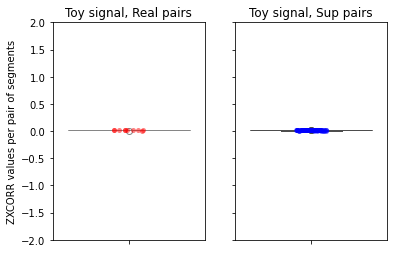

In [26]:
seg_sims = susy.zxcorr_sims(sig_A_segments,sig_B_segments,maxlag)

fig, axs = plt.subplots(1,2,sharey = 'all',figsize=(6,4))
sns.boxplot(y=seg_sims['Real'],color = 'pink', ax=axs[0])
sns.stripplot(y=seg_sims['Real'],alpha=0.5,color = 'red', ax=axs[0])
axs[0].set_title('Toy signal, Real pairs')
sns.boxplot(y=seg_sims['Sup'], color = 'aqua', ax=axs[1])
sns.stripplot(y=seg_sims['Sup'],alpha=0.5,color = 'blue', ax=axs[1])
axs[1].set_title('Toy signal, Sup pairs')
axs[0].set_ylabel('ZXCORR values per pair of segments')
axs[0].set_ylim([-2,2])
plt.show()

Across all combinations of these signals' segments, the average Z-transformed cross-correlations are incredibly small, so we have to change the scale of these plots to make the distributions visible, rather than use the range suitable for the low frequency signals. 

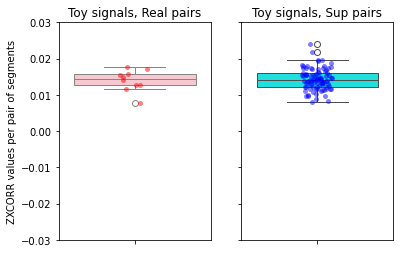

In [27]:
fig, axs = plt.subplots(1,2,sharey = 'all',figsize=(6,4))
sns.boxplot(y=seg_sims['Real'],color = 'pink', ax=axs[0])
sns.stripplot(y=seg_sims['Real'],alpha=0.5,color = 'red', ax=axs[0])
axs[0].set_title('Toy signals, Real pairs')
sns.boxplot(y=seg_sims['Sup'], color = 'aqua', ax=axs[1])
sns.stripplot(y=seg_sims['Sup'],alpha=0.5,color = 'blue', ax=axs[1])
axs[1].set_title('Toy signals, Sup pairs')
axs[0].set_ylabel('ZXCORR values per pair of segments')
axs[0].set_ylim([-0.03,0.03])
plt.show()

In [28]:
ttest = pg.ttest(seg_sims['Real'], seg_sims['Sup'],alternative='greater').round(2)
print(ttest)

           T    dof alternative  p-val        CI95%  cohen-d   BF10  power
T-test -0.29  11.08     greater   0.61  [-0.0, inf]      0.1  0.665   0.03


On these toy signals with an identical oscillatory component at 0.2 Hz, SUSY failed to capture any true "synchronous" coordination because of how the analysis parameters interacted with the informative component of these signals. 

1. The segmentation interval of 30 s cuts this signal on the dominant frequencies period (5 s wave length), making all the segments nearly identical.
2. The average cross-correlation between signals that fully cycle in phase relationships over the range of lags (10 s/ 5 s = 2) can only produce extremely low numbers. The resultant spread of ZXCORR values over the segment pairs is entirely due to the white noise component. 

This example isn't completely fair as the synthetic values allow for a more absolute erasure of information that might be found in natural signals. However, it demonstrates how signals with oscillatory components shorter than the cross-correlations are not reliably captured by this measure of shared information.

## Signals with identical high frequency components at 0.13 Hz

Here is an example of signals with a shared frequency component that isn't a simple divisor of the cross-correlation range or segmentation interval.

Pearson r(A,B) = 0.91


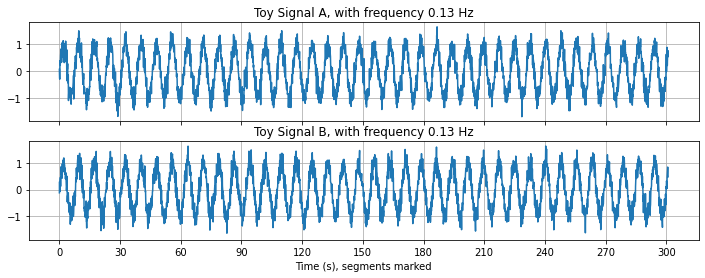

In [29]:
# generate toy signals
tag = 'Toy_0p13hz'
freq = 0.13 # Hz, rate of sin wave generated

Common_signal =np.sin(((2*np.pi)*freq)*times)
sig_A = Common_signal + susy.white_noise(0.1, samplerate, len(times))
sig_B = Common_signal + susy.white_noise(0.1, samplerate, len(times))
print('Pearson r(A,B) = ' + str(sp.stats.pearsonr(sig_A, sig_B).statistic.round(2)))

# cut them into segments
sig_A_segments = susy.sig_seg(sig_A,seg_size*samplerate)
sig_B_segments = susy.sig_seg(sig_B,seg_size*samplerate)
n = len(sig_A_segments)

# plot signals and segmentation
fig, axs = plt.subplots(2,1, sharex='all',sharey='all',figsize=(12,4))
axs[0].plot(times,sig_A)
axs[0].set_title('Toy Signal A, with frequency ' + str(freq) + ' Hz')
axs[1].plot(times,sig_B)
axs[1].set_title('Toy Signal B, with frequency ' + str(freq) + ' Hz')
axs[1].set_xlabel('Time (s), segments marked')
axs[1].set_xticks(segment_boundaries)
axs[0].grid()
axs[1].grid()
plt.savefig('./plots/'+tag+'_pair.png', bbox_inches = 'tight',dpi = 100)
plt.show()

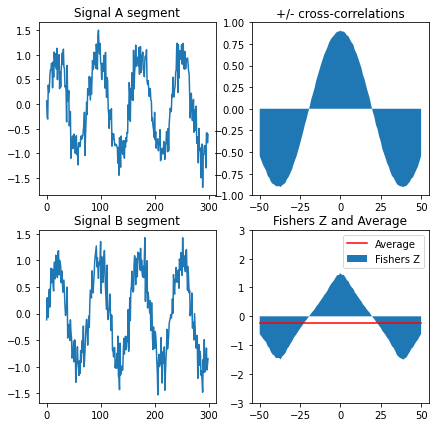

ZXCORR mean for matching segments A0 and B0: -0.249


In [30]:
# demo cross correlation between segments that match
segment_i = 0 # demonstrate on a signal segment 
segment_j = segment_i # matching segments

zx = susy.plot_zxcorr_pairs(sig_A_segments[segment_i],sig_B_segments[segment_j],maxlag)
print('ZXCORR mean for matching segments A0 and B0: '+ str(zx.round(3)))

These two segments should match because they share a very strong oscillatory component that is perfectly synchronised, however the calculated average Z-transformed cross-correlation is actually mildly negative. This is because the signal oscillates a bit more than once over 10-s cross-correlation range.

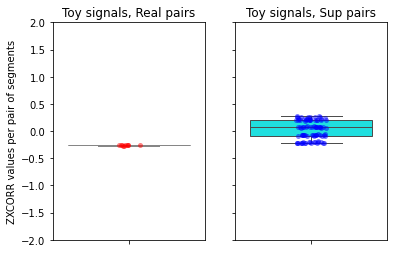

In [31]:
seg_sims = susy.zxcorr_sims(sig_A_segments,sig_B_segments,maxlag)

# show the difference in zxcorr similarity values between real 
# and "supplementary" signal segment pairs
fig, axs = plt.subplots(1,2,sharey = 'all',figsize=(6,4))
sns.boxplot(y=seg_sims['Real'],color = 'pink', ax=axs[0])
sns.stripplot(y=seg_sims['Real'],alpha=0.5,color = 'red', ax=axs[0])
axs[0].set_title('Toy signals, Real pairs')
sns.boxplot(y=seg_sims['Sup'], color = 'aqua', ax=axs[1])
sns.stripplot(y=seg_sims['Sup'],alpha=0.5,color = 'blue', ax=axs[1])
axs[1].set_title('Toy signals, Sup pairs')
axs[0].set_ylabel('ZXCORR values per pair of segments')
axs[0].set_ylim([-2,2])
plt.show()

In [32]:
ttest = pg.ttest(seg_sims['Real'], seg_sims['Sup'],alternative='greater').round(2)
print(ttest)

            T    dof alternative  p-val         CI95%  cohen-d       BF10  \
T-test -15.85  91.69     greater    1.0  [-0.32, inf]     1.77  3.586e-26   

        power  
T-test    0.0  


For this combination of signal frequency and cross-correlation parameters, a two-tailed t-test between the values from the real segment pairs and the supplementary segment pairs would show a significant difference, however the distinction would be in THE WRONG DIRECTION, suggesting these real signal pairs are anti-correlated relative to the supplementary component pairs. By construction, these signals sharing an identical and perfectly synchronous component at 0.13 Hz, but this average cross-correlation measure produces nonsense results instead.

## Signals with identical oscillatory components that drift 0.13-0.2 Hz

Most of the signals SUSY is meant to evaluate are not so stiff as to maintain a constant oscillation rate like these previous toy examples. To show how a changing oscillation rate does not eleviate the risk of false negatives with SUSY, this toy example modulates the rate of oscillations in the shared "high" frequency component of the two signals. 

Pearson r(A,B) = 0.91


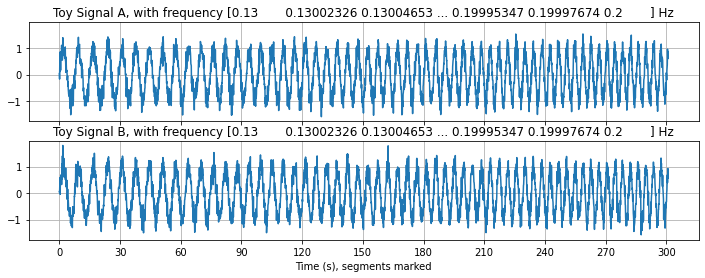

In [33]:
# generate toy signals
tag = 'Toy_0p13_0.2hz'
freq = 0.13 + 0.07*times/max(times) # Hz, rate of sin wave generated 

Common_signal =np.sin(((2*np.pi)*freq)*times)
sig_A = Common_signal + susy.white_noise(0.1, samplerate, len(times))
sig_B = Common_signal + susy.white_noise(0.1, samplerate, len(times))
print('Pearson r(A,B) = ' + str(sp.stats.pearsonr(sig_A, sig_B).statistic.round(2)))

# cut them into segments
sig_A_segments = susy.sig_seg(sig_A,seg_size*samplerate)
sig_B_segments = susy.sig_seg(sig_B,seg_size*samplerate)
n = len(sig_A_segments)

# plot signals and segmentation
fig, axs = plt.subplots(2,1, sharex='all',sharey='all',figsize=(12,4))
axs[0].plot(times,sig_A)
axs[0].set_title('Toy Signal A, with frequency ' + str(freq) + ' Hz')
axs[1].plot(times,sig_B)
axs[1].set_title('Toy Signal B, with frequency ' + str(freq) + ' Hz')
axs[1].set_xlabel('Time (s), segments marked')
axs[1].set_xticks(segment_boundaries)
axs[0].grid()
axs[1].grid()
plt.savefig('./plots/'+tag+'_pair.png', bbox_inches = 'tight',dpi = 100)
plt.show()

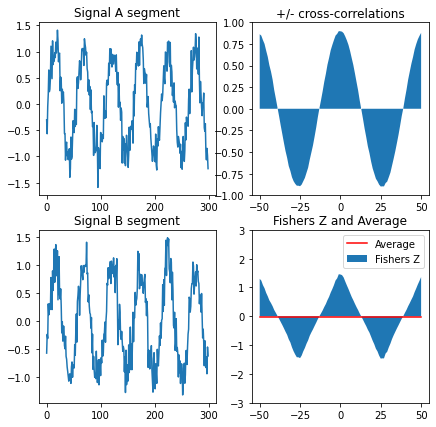

ZXCORR mean for matching segments A4 and B4: -0.039


In [34]:
# demo cross correlation between segments that match
segment_i = 4 # demonstrate on a signal segment 
segment_j = segment_i # matching segments

zx = susy.plot_zxcorr_pairs(sig_A_segments[segment_i],sig_B_segments[segment_j],maxlag)
print('ZXCORR mean for matching segments A4 and B4: '+ str(zx.round(3)))

Values for matching segments will be very small, varying a bit positive or negative with the way the cross-correlation range cuts the number of cycles. Values of supplementary pairs should also be very small, with oscillations attenuating values that wouldn't be high to begin with. 

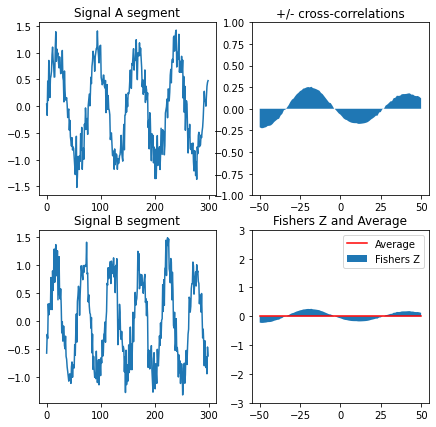

ZXCORR mean for non-matching segments A0 and B4: 0.018


In [35]:
# demo cross correlation between segments that match
segment_i = 0 # demonstrate on a signal segment 
segment_j = 4 # non-matching segment

zx = susy.plot_zxcorr_pairs(sig_A_segments[segment_i],sig_B_segments[segment_j],maxlag)
print('ZXCORR mean for non-matching segments A0 and B4: '+ str(zx.round(3)))

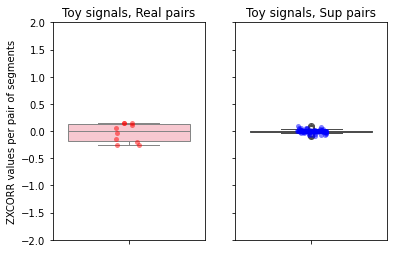

In [36]:
seg_sims = susy.zxcorr_sims(sig_A_segments,sig_B_segments,maxlag)

# show the difference in zxcorr similarity values between real 
# and "supplimentary" signal segment pairs
fig, axs = plt.subplots(1,2,sharey = 'all',figsize=(6,4))
sns.boxplot(y=seg_sims['Real'],color = 'pink', ax=axs[0])
sns.stripplot(y=seg_sims['Real'],alpha=0.5,color = 'red', ax=axs[0])
axs[0].set_title('Toy signals, Real pairs')
sns.boxplot(y=seg_sims['Sup'], color = 'aqua', ax=axs[1])
sns.stripplot(y=seg_sims['Sup'],alpha=0.5,color = 'blue', ax=axs[1])
axs[1].set_title('Toy signals, Sup pairs')
axs[0].set_ylabel('ZXCORR values per pair of segments')
axs[0].set_ylim([-2,2])
plt.show()

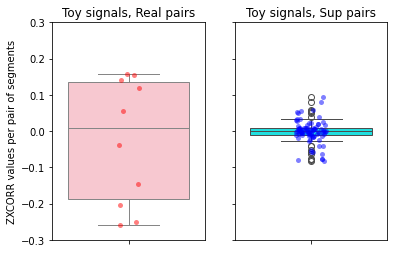

In [37]:
# zoom in
fig, axs = plt.subplots(1,2,sharey = 'all',figsize=(6,4))
sns.boxplot(y=seg_sims['Real'],color = 'pink', ax=axs[0])
sns.stripplot(y=seg_sims['Real'],alpha=0.5,color = 'red', ax=axs[0])
axs[0].set_title('Toy signals, Real pairs')
sns.boxplot(y=seg_sims['Sup'], color = 'aqua', ax=axs[1])
sns.stripplot(y=seg_sims['Sup'],alpha=0.5,color = 'blue', ax=axs[1])
axs[1].set_title('Toy signals, Sup pairs')
axs[0].set_ylabel('ZXCORR values per pair of segments')
axs[0].set_ylim([-0.3,0.3])
plt.show()

In [38]:
ttest = pg.ttest(seg_sims['Real'], seg_sims['Sup'],alternative='greater').round(2)
print(ttest)

           T   dof alternative  p-val         CI95%  cohen-d   BF10  power
T-test -0.47  9.06     greater   0.68  [-0.13, inf]     0.43  0.701    0.0


Again, the distribution of values for the real segment pairs is noticeably different from the supplementary pairs, but in this case it is in their variance, not in the means. This average Z-transformed cross-correlation measure of similarity fails to capture the shared information in the high frequency component, even when that component is also identically varying in frequency. 

## Signals with low and high frequency components

To demonstrate the relative value of high and low frequency components on SUSY's ability to pick out information.

###  Signals with identical low frequency and different high frequency components
here first is a pair of signals that have the same low frequency oscillatory component with non-matching high frequency components.

Pearson r(A,B) = 0.46


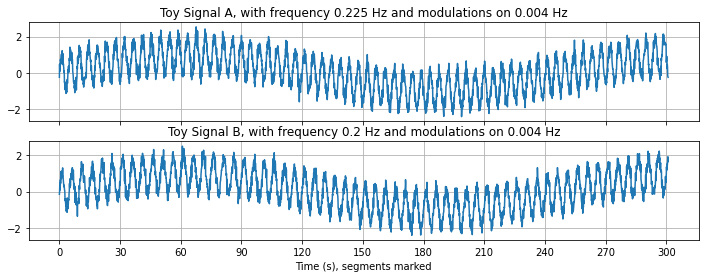

In [40]:
tag = 'Toy_same_diff'

# generate toy signals
freq1 = 0.225 # Hz, rate of sin wave generated, not a divisor of the cross correlation range
freq2 = 0.2 # Hz, rate of sin wave generated, not a divisor of the cross correlation range
modfreq = 0.004
Common_Signal = +np.sin(((2*np.pi)*modfreq)*times)
sig_A = Common_Signal + np.sin(((2*np.pi)*freq1)*times) + susy.white_noise(0.1, samplerate, len(times))
sig_B = Common_Signal + np.sin(((2*np.pi)*freq2)*times) + susy.white_noise(0.1, samplerate, len(times))
print('Pearson r(A,B) = ' + str(sp.stats.pearsonr(sig_A, sig_B).statistic.round(2)))

# cut them into segments
sig_A_segments = susy.sig_seg(sig_A,seg_size*samplerate)
sig_B_segments = susy.sig_seg(sig_B,seg_size*samplerate)
n = len(sig_A_segments)

# plot signals and segmentation
fig, axs = plt.subplots(2,1, sharex='all',sharey='all',figsize=(12,4))
axs[0].plot(times,sig_A)
axs[0].set_title('Toy Signal A, with frequency ' + str(freq1) + ' Hz and modulations on ' + str(modfreq) + ' Hz')
axs[1].plot(times,sig_B)
axs[1].set_title('Toy Signal B, with frequency ' + str(freq2) + ' Hz and modulations on ' + str(modfreq) + ' Hz')
axs[1].set_xlabel('Time (s), segments marked')
axs[1].set_xticks(segment_boundaries)
axs[0].grid()
axs[1].grid()
plt.savefig('./plots/'+tag+'_pair.png', bbox_inches = 'tight',dpi = 100)
plt.show()

Mathematically, these two signals are equally similar and different: the matching slow component is of the same amplitude as the faster contrasting components. And the pearson correlation over the full sequence shows this fairly well (r = 0.46). 

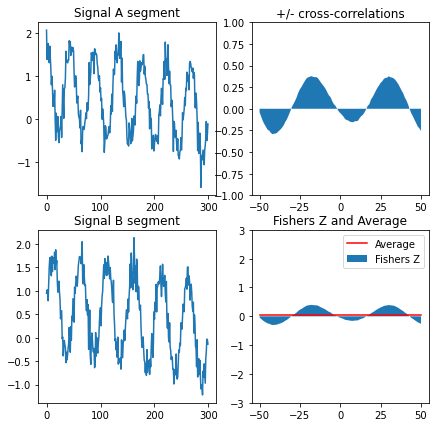

ZXCORR mean for matching segments A3 and B3: 0.062


In [41]:
# demo cross correlation between segments that match
segment_i = 3 # demonstrate on a signal segment 
segment_j = segment_i # matching segments

zx = susy.plot_zxcorr_pairs(sig_A_segments[segment_i],sig_B_segments[segment_j],maxlag)
print('ZXCORR mean for matching segments A3 and B3: '+ str(zx.round(3)))

The high frequency oscillatory component strongly reduces the shared information between matching segments, however there is a chance for the slower component to come through. 

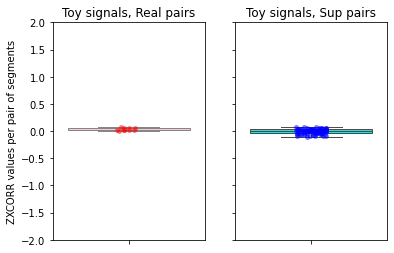

In [42]:
seg_sims = susy.zxcorr_sims(sig_A_segments,sig_B_segments,maxlag)

# show the difference in zxcorr similarity values between real 
# and "supplimentary" signal segment pairs
fig, axs = plt.subplots(1,2,sharey = 'all',figsize=(6,4))
sns.boxplot(y=seg_sims['Real'],color = 'pink', ax=axs[0])
sns.stripplot(y=seg_sims['Real'],alpha=0.5,color = 'red', ax=axs[0])
axs[0].set_title('Toy signals, Real pairs')
sns.boxplot(y=seg_sims['Sup'], color = 'aqua', ax=axs[1])
sns.stripplot(y=seg_sims['Sup'],alpha=0.5,color = 'blue', ax=axs[1])
axs[1].set_title('Toy signals, Sup pairs')
axs[0].set_ylabel('ZXCORR values per pair of segments')
axs[0].set_ylim([-2,2])
plt.show()

Because of the effect of the high frequency oscillations in these signals, it is necessary to zoom in.

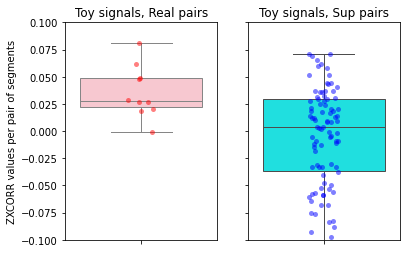

In [43]:
# zoom in
fig, axs = plt.subplots(1,2,sharey = 'all',figsize=(6,4))
sns.boxplot(y=seg_sims['Real'],color = 'pink', ax=axs[0])
sns.stripplot(y=seg_sims['Real'],alpha=0.5,color = 'red', ax=axs[0])
axs[0].set_title('Toy signals, Real pairs')
sns.boxplot(y=seg_sims['Sup'], color = 'aqua', ax=axs[1])
sns.stripplot(y=seg_sims['Sup'],alpha=0.5,color = 'blue', ax=axs[1])
axs[1].set_title('Toy signals, Sup pairs')
axs[0].set_ylabel('ZXCORR values per pair of segments')
axs[0].set_ylim([-0.1,0.1])
plt.show()

In [44]:
ttest = pg.ttest(seg_sims['Real'], seg_sims['Sup'],alternative='greater').round(2)
print(ttest)

           T    dof alternative  p-val        CI95%  cohen-d      BF10  power
T-test  4.55  16.89     greater    0.0  [0.03, inf]     0.95  1962.155   0.88


Here we see how resilient SUSY can be for picking out the shared trajectory of the slower component despite substantial interferences from equally large but different high frequency components. By comparing the real and supplementary values for the cross-correlation, the systematic influence of the slow component seems well-captured. However, the results would be even stronger, and maybe easier to understand, if signals passed to SUSY were already lowpass-filtered with the cutoff of the cross-correlation range. 

### Signals with identical slow frequency and modulating high frequency components

However, SUSY's capacity to pick out a shared low frequency signal around high frequency oscillations is challenged when the high frequency component is also changing frequency. This is true even when the high frequency components are also identical.

Pearson r(A,B) = 0.95


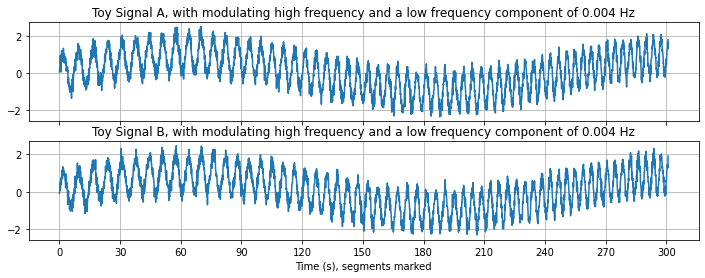

In [46]:
tag = 'Toy_AM_same_carrier'

# generate toy signals
freq = 0.13 + 0.07*times/max(times) # Hz, rate of sin wave generated 
modfreq = 0.004

Common_Signal = +np.sin(((2*np.pi)*modfreq)*times)+ np.sin(((2*np.pi)*freq)*times)
sig_A = Common_Signal + susy.white_noise(0.1, samplerate, len(times))
sig_B = Common_Signal + susy.white_noise(0.1, samplerate, len(times))
print('Pearson r(A,B) = ' + str(sp.stats.pearsonr(sig_A, sig_B).statistic.round(2)))

# cut them into segments
sig_A_segments = susy.sig_seg(sig_A,seg_size*samplerate)
sig_B_segments = susy.sig_seg(sig_B,seg_size*samplerate)
n = len(sig_A_segments)

# plot signals and segmentation
fig, axs = plt.subplots(2,1, sharex='all',sharey='all',figsize=(12,4))
axs[0].plot(times,sig_A)
axs[0].set_title('Toy Signal A, with modulating high frequency and a low frequency component of ' + str(modfreq) + ' Hz')
axs[1].plot(times,sig_B)
axs[1].set_title('Toy Signal B, with modulating high frequency and a low frequency component of ' + str(modfreq) + ' Hz')
axs[1].set_xlabel('Time (s), segments marked')
axs[1].set_xticks(segment_boundaries)
axs[0].grid()
axs[1].grid()
plt.savefig('./plots/'+tag+'_pair.png', bbox_inches = 'tight',dpi = 100)
plt.show()

Here the two signals are again nearly identical, with the same frequencies in high and low components, though the high frequency component is changing slowly like in a previous example. The Pearson correlation for the full signals is extremely high (r = 0.95). 

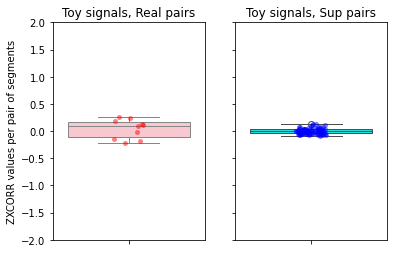

In [47]:
seg_sims = susy.zxcorr_sims(sig_A_segments,sig_B_segments,maxlag)

# show the difference in zxcorr similarity values between real 
# and "supplementary" signal segment pairs
fig, axs = plt.subplots(1,2,sharey = 'all',figsize=(6,4))
sns.boxplot(y=seg_sims['Real'],color = 'pink', ax=axs[0])
sns.stripplot(y=seg_sims['Real'],alpha=0.5,color = 'red', ax=axs[0])
axs[0].set_title('Toy signals, Real pairs')
sns.boxplot(y=seg_sims['Sup'], color = 'aqua', ax=axs[1])
sns.stripplot(y=seg_sims['Sup'],alpha=0.5,color = 'blue', ax=axs[1])
axs[1].set_title('Toy signals, Sup pairs')
axs[0].set_ylabel('ZXCORR values per pair of segments')
axs[0].set_ylim([-2,2])
plt.show()

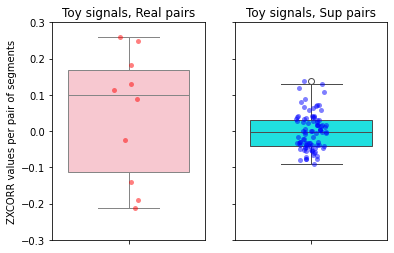

In [48]:
# zoom in
fig, axs = plt.subplots(1,2,sharey = 'all',figsize=(6,4))
sns.boxplot(y=seg_sims['Real'],color = 'pink', ax=axs[0])
sns.stripplot(y=seg_sims['Real'],alpha=0.5,color = 'red', ax=axs[0])
axs[0].set_title('Toy signals, Real pairs')
sns.boxplot(y=seg_sims['Sup'], color = 'aqua', ax=axs[1])
sns.stripplot(y=seg_sims['Sup'],alpha=0.5,color = 'blue', ax=axs[1])
axs[1].set_title('Toy signals, Sup pairs')
axs[0].set_ylabel('ZXCORR values per pair of segments')
axs[0].set_ylim([-0.3,0.3])
plt.show()

In [49]:
ttest = pg.ttest(seg_sims['Real'], seg_sims['Sup'],alternative='greater').round(2)
print(ttest)

           T   dof alternative  p-val         CI95%  cohen-d   BF10  power
T-test  0.84  9.17     greater   0.21  [-0.06, inf]     0.65  0.845   0.62


The noise from the changing interaction of the cross-correlation range with the high frequency component is strong enough to make the lower frequency component imperceptible to SUSY. Again, low-pass filtering these signals first would better expose the shared information that can be captured with this cross-correlation measure on signals with high frequency components. Even when the high frequency component is identical, it can interfere.

# SUSY on real respiration measurements during music listening

Having shown how SUSY can fail to capture shared information in synthetic signal pairs at high frequencies, let's consider a real data example.

Respiration belts are often used to capture respiratory behaviour in listeners and performers during music. These chest stretch measurements in their raw form contain a big signal component that is basically oscillatory at a rate of around 0.3-0.4 Hz, and often researchers extract the feature of respiratory rate rather than trying to handle the slightly skewed shape of inspiration-expiration cycles. However, there is some evidence that music listeners can adjust the timing of their individual breaths to fit with the music they are listening to (Upham, 2018). From my dissertation on respiratory phase alignment to heard music, I am sharing some respiration sequences from a single participant while listening multiple times to the same piece of music. By other calculations, it has been shown that these listenings produced measurably similar respiration sequences, particularly in the timing of inspirations and post-expiration pauses. Let's see how well SUSY can assess respiratory synchrony between a pair of these listenings. 

Note because this piece is shorter than many others used with SUSY, measurements only lasting about 160 seconds, we will start with smaller segment and cross-correlation range parameters than above: only 15 s instead of 30 s per segment, with 8 s cross correlation range (+/- 4 s). 

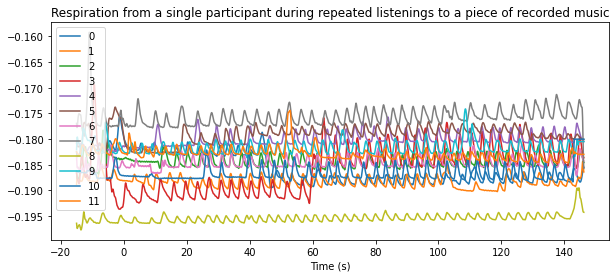

In [50]:
Repeated_Resps = pd.read_csv('./data/P2_listenings_Rosier.csv',index_col = 0)
samplerate = 20 # Hz sample rate on the signal being evaluated
times = np.array(Repeated_Resps.index)
dur = times[-1]-times[0]

Repeated_Resps.plot(figsize=[10,4])
plt.title('Respiration from a single participant during repeated listenings to a piece of recorded music')
plt.xlabel('Time (s)')
plt.show()

In [51]:
seg_size = 15 # seconds
segment_boundaries = np.arange(times[0],times[-1],seg_size)

xcorr_range = 4 # +/- 4 seconds 
maxlag = xcorr_range*samplerate

We have 12 respiration sequences from the same listener to a recording of a folk song performed in a capella, however this analysis is just of pairwise (dyadic) SUSY, so I've chosen two later recordings of respiration sequences that are already known to share similar breath timing. 

Pearson r(A,B) = 0.21


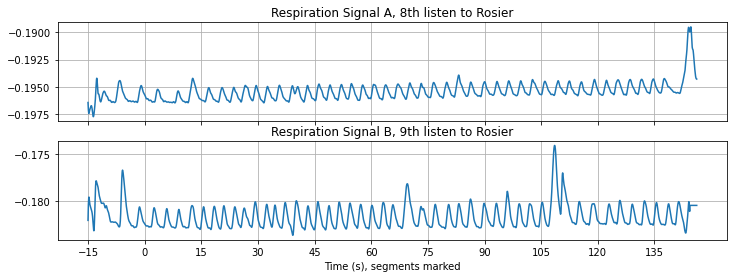

In [52]:
tag = 'Resp_pair'
# select a pair of signals, here respiration from later listenings
sig_A = np.array(Repeated_Resps['8'].values)
sig_B = np.array(Repeated_Resps['9'].values)
print('Pearson r(A,B) = ' + str(sp.stats.pearsonr(sig_A, sig_B).statistic.round(2)))

sig_A_segments = susy.sig_seg(sig_A,seg_size*samplerate)
sig_B_segments = susy.sig_seg(sig_B,seg_size*samplerate)
n = len(sig_A_segments)

# plot signals and segmentation
fig, axs = plt.subplots(2,1, sharex='all',figsize=(12,4))
axs[0].plot(times,sig_A)
axs[0].set_title('Respiration Signal A, 8th listen to Rosier')
axs[1].plot(times,sig_B)
axs[1].set_title('Respiration Signal B, 9th listen to Rosier')
axs[1].set_xlabel('Time (s), segments marked')
axs[1].set_xticks(segment_boundaries)
axs[0].grid()
axs[1].grid()
plt.savefig('./plots/'+tag+'_pair.png', bbox_inches = 'tight',dpi = 100)
plt.show()


Respiration signals are not perfectly oscillatory and they have different ranges and trends, resulting in a fairly low Pearson correlation across this whole interval (r = 0.21), at least relative to all the synthetic signals tested above.

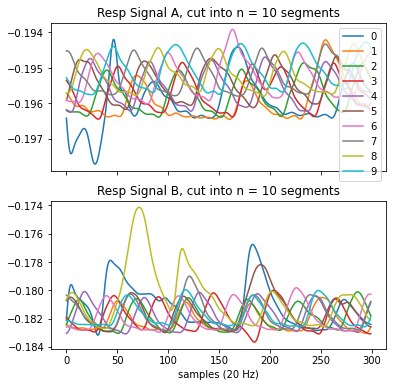

In [53]:
# plot segments
fig, axs = plt.subplots(2,1, sharex='all',figsize=(6,6))
for i in range(n):
    axs[0].plot(sig_A_segments[i],label=i)
    axs[1].plot(sig_B_segments[i],label=i)
axs[0].set_title('Resp Signal A, cut into n = '+str(n)+' segments')
axs[1].set_title('Resp Signal B, cut into n = '+str(n)+' segments')
axs[1].set_xlabel('samples ('+str(samplerate)+' Hz)')
axs[0].legend()
plt.show()

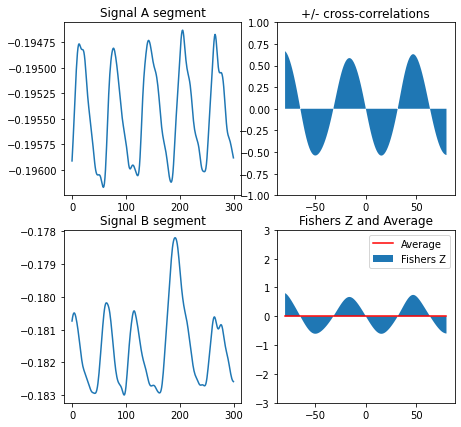

ZXCORR mean for matching segments A5 and B5: 0.023


In [54]:
# demo cross correlation between segments that match
segment_i = 5 # demonstrate on a signal segment 
segment_j = segment_i # matching segments

zx = susy.plot_zxcorr_pairs(sig_A_segments[segment_i],sig_B_segments[segment_j],maxlag)
print('ZXCORR mean for matching segments A5 and B5: '+ str(zx.round(3)))

Like the synthetic signals with high frequency components, these segments of respiration signals phase against each other over the wide cross-correlation lag range, making for very low average values that have more to do with the signal oscillation periods than their synchrony. This is an issue for segments that match as well as supplementary pairs.

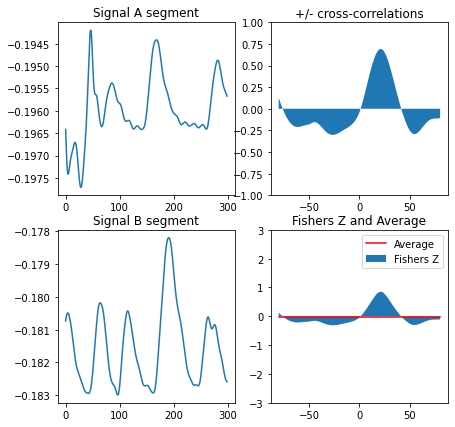

ZXCORR mean for non-matching segments A0 and B5: -0.022


In [57]:
# demo cross correlation between segments that don't match
segment_i = 0 # demonstrate on a signal segment 
segment_j = 5 # not matching segment

zx = susy.plot_zxcorr_pairs(sig_A_segments[segment_i],sig_B_segments[segment_j],maxlag)
print('ZXCORR mean for non-matching segments A0 and B5: '+ str(zx.round(3)))

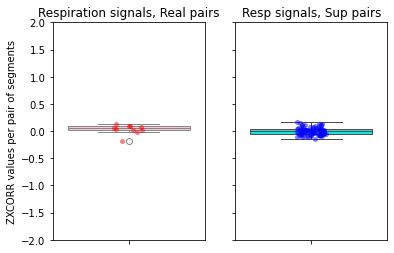

In [58]:
seg_sims = susy.zxcorr_sims(sig_A_segments,sig_B_segments,maxlag)

# show the difference in zxcorr similarity values between real 
# and "supplimentary" signal segment pairs
fig, axs = plt.subplots(1,2,sharey = 'all',figsize=(6,4))
sns.boxplot(y=seg_sims['Real'],color = 'pink', ax=axs[0])
sns.stripplot(y=seg_sims['Real'],alpha=0.5,color = 'red', ax=axs[0])
axs[0].set_title('Respiration signals, Real pairs')
sns.boxplot(y=seg_sims['Sup'], color = 'aqua', ax=axs[1])
sns.stripplot(y=seg_sims['Sup'],alpha=0.5,color = 'blue', ax=axs[1])
axs[1].set_title('Resp signals, Sup pairs')
axs[0].set_ylabel('ZXCORR values per pair of segments')
axs[0].set_ylim([-2,2])
plt.show()

And like the synthetic signals with high frequency components, it's necessary to zoom into the measure values range to even see if there is a difference in distributions.

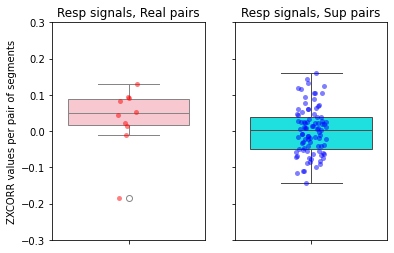

In [59]:
fig, axs = plt.subplots(1,2,sharey = 'all',figsize=(6,4))
sns.boxplot(y=seg_sims['Real'],color = 'pink', ax=axs[0])
sns.stripplot(y=seg_sims['Real'],alpha=0.5,color = 'red', ax=axs[0])
axs[0].set_title('Resp signals, Real pairs')
sns.boxplot(y=seg_sims['Sup'], color = 'aqua', ax=axs[1])
sns.stripplot(y=seg_sims['Sup'],alpha=0.5,color = 'blue', ax=axs[1])
axs[1].set_title('Resp signals, Sup pairs')
axs[0].set_ylabel('ZXCORR values per pair of segments')
axs[0].set_ylim([-0.3,0.3])
plt.show()

In [60]:
ttest = pg.ttest(seg_sims['Real'], seg_sims['Sup'],alternative='greater').round(2)
print(ttest)

           T    dof alternative  p-val         CI95%  cohen-d   BF10  power
T-test  1.11  10.13     greater   0.15  [-0.02, inf]     0.47  1.039   0.41


With a cross-correlation range greater than the (average) respiration period, the difference between real segments and supplementary pairings is not enough to test as significantly different.


However, through all this, I've been arguing that the issue is the cross-correlation range parameters. It may be that a smaller range would allow for better information to survive, say an interval that is SMALLER than the average respiratory period (3-4 s). 

So let's try a 1 second interval.

In [61]:
xcorr_range = 0.5 #+/- 0.5 s meaning 1 second cross correlation range. 
maxlag = int(xcorr_range*samplerate) # +/-

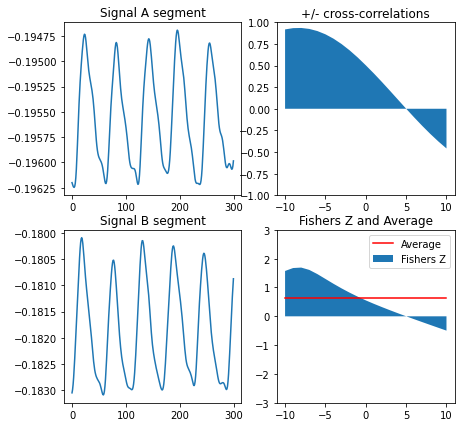

ZXCORR mean for matching segments A4 and B4: 0.621


In [64]:
# demo cross correlation between segments that match
segment_i = 4 # demonstrate on a signal segment 
segment_j = segment_i # matching segments

zx = susy.plot_zxcorr_pairs(sig_A_segments[segment_i],sig_B_segments[segment_j],maxlag)
print('ZXCORR mean for matching segments A4 and B4: '+ str(zx.round(3)))

This kind of cross-correlation still gets a spread of values, but doesn't cycle between positive and negative multiple times. And does that improve the distinction between real and supplementary segment pairs between these two signals?

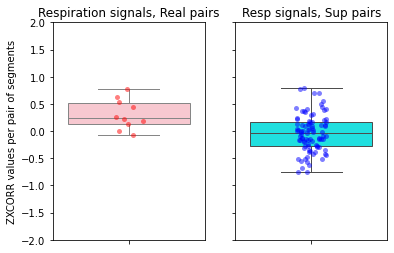

In [63]:
seg_sims = susy.zxcorr_sims(sig_A_segments,sig_B_segments,maxlag)

# show the difference in zxcorr similarity values between real 
# and "supplimentary" signal segment pairs
fig, axs = plt.subplots(1,2,sharey = 'all',figsize=(6,4))
sns.boxplot(y=seg_sims['Real'],color = 'pink', ax=axs[0])
sns.stripplot(y=seg_sims['Real'],alpha=0.5,color = 'red', ax=axs[0])
axs[0].set_title('Respiration signals, Real pairs')
sns.boxplot(y=seg_sims['Sup'], color = 'aqua', ax=axs[1])
sns.stripplot(y=seg_sims['Sup'],alpha=0.5,color = 'blue', ax=axs[1])
axs[1].set_title('Resp signals, Sup pairs')
axs[0].set_ylabel('ZXCORR values per pair of segments')
axs[0].set_ylim([-2,2])
plt.show()

In [90]:
ttest = pg.ttest(seg_sims['Real'], seg_sims['Sup'],alternative='greater').round(3)
print(ttest)

            T     dof alternative  p-val        CI95%  cohen-d     BF10  power
T-test  3.679  12.262     greater  0.002  [0.18, inf]    1.037  127.061  0.926


When the cross-correlation range doesn't exceed the period of these signals' dominant frequency component (respiration rate), there is a chance of identifying the shared information in respiratory phase between these two signals. 

To demonstrate this even more clearly, we can show how changing the cross-correlation range changes the effect size of the difference between the real and supplementary combinations of segments from this real pair of respiration measurements to the same music.

In [65]:
# define range of lag values to evaluate the significance of cross correlation results
xcorr_ranges = np.arange(4,0,-0.2) 
xcorr_ranges

array([4. , 3.8, 3.6, 3.4, 3.2, 3. , 2.8, 2.6, 2.4, 2.2, 2. , 1.8, 1.6,
       1.4, 1.2, 1. , 0.8, 0.6, 0.4, 0.2])

In [66]:
df_tests = pd.DataFrame(index = xcorr_ranges,columns=ttest.columns)

for r in xcorr_ranges:
    maxlags = int(r*samplerate)
    seg_sims = susy.zxcorr_sims(sig_A_segments,sig_B_segments,maxlags)
    ttest = pg.ttest(seg_sims['Real'], seg_sims['Sup'],alternative='greater')
    df_tests.loc[r,:] =ttest.values
df_tests

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
4.0,1.11384,10.130602,greater,0.145538,"[-0.02, inf]",0.471704,1.039,0.405353
3.8,1.312986,10.070352,greater,0.109159,"[-0.01, inf]",0.567821,1.254,0.518677
3.6,1.399065,9.941447,greater,0.096105,"[-0.01, inf]",0.635262,1.373,0.597837
3.4,1.288404,9.80163,greater,0.113593,"[-0.01, inf]",0.621243,1.223,0.581599
3.2,0.95641,9.93894,greater,0.180775,"[-0.02, inf]",0.434707,0.916,0.363268
3.0,0.358618,10.786969,greater,0.363401,"[-0.03, inf]",0.127195,0.676,0.102775
2.8,-0.407123,12.601737,greater,0.654626,"[-0.04, inf]",0.110578,0.686,0.024173
2.6,-1.081121,14.264465,greater,0.851209,"[-0.06, inf]",0.256503,0.989,0.007996
2.4,-1.483965,14.709787,greater,0.920536,"[-0.07, inf]",0.342472,0.662,0.003847
2.2,-1.462602,14.233963,greater,0.917348,"[-0.07, inf]",0.347706,0.679,0.003672


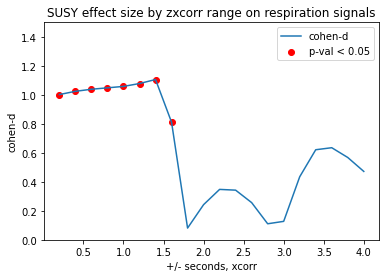

In [67]:
df_tests['cohen-d'].plot()
plt.xlabel('+/- seconds, xcorr')
plt.title('SUSY effect size by zxcorr range on respiration signals')
plt.ylabel('cohen-d')
a = df_tests.loc[df_tests['p-val']<0.05,'cohen-d']
plt.scatter(a.index,a.values,color='r',label='p-val < 0.05')
plt.legend()
plt.ylim([0,1.5])
plt.savefig('./plots/ES_zxcorrRange_Resp.png', bbox_inches = 'tight',dpi = 300)

plt.show()

The above figure reports the Cohen's d (effect size) for SUSY for small cross-correlation ranges (minimum 0.4 s up to 8 s), with those ranges identifying significantly different Real segment values marked with red dots. Ranges below 3.4 s (+/- 1.8 s) successfully find shared information between these signals, while wider cross-correlations miss the boat. 

In other words: once the cross-correlation range is smaller than the average respiration period, phasic information can be captured and this listener's repeated alignment of respiratory phase to moments in the music is detected as well synched by SUSY. 


This measured alignment isn't just a consequence of the autocorrelation within these respiratory sequences. If we offset these signals by as little as a second, shared information between the two measurements disapear. 

Pearson r(A,B) = 0.03


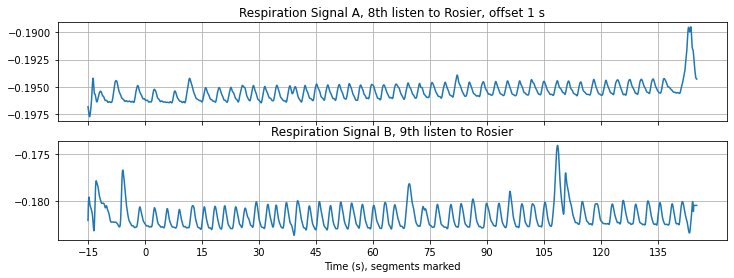

In [75]:
sig_A = np.array(Repeated_Resps['8'].values[20:]) # sample rate is 20 Hz
sig_B = np.array(Repeated_Resps['9'].values[:-20])
print('Pearson r(A,B) = ' + str(sp.stats.pearsonr(sig_A, sig_B).statistic.round(2)))

sig_A_segments = susy.sig_seg(sig_A,seg_size*samplerate)
sig_B_segments = susy.sig_seg(sig_B,seg_size*samplerate)
n = len(sig_A_segments)
# plot signals and segmentation
fig, axs = plt.subplots(2,1, sharex='all',figsize=(12,4))
axs[0].plot(times[:-20],sig_A)
axs[0].set_title('Respiration Signal A, 8th listen to Rosier, offset 1 s')
axs[1].plot(times[:-20],sig_B)
axs[1].set_title('Respiration Signal B, 9th listen to Rosier')
axs[1].set_xlabel('Time (s), segments marked')
axs[1].set_xticks(segment_boundaries)
axs[0].grid()
axs[1].grid()
plt.show()

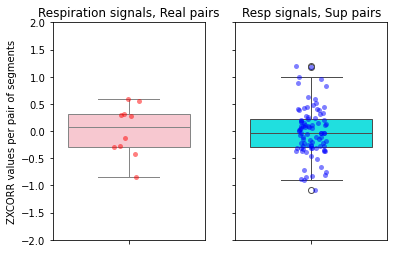

In [71]:
maxlag = int(xcorr_ranges[-1]*samplerate)
seg_sims = susy.zxcorr_sims(sig_A_segments,sig_B_segments,maxlag)

# show the difference in zxcorr similarity values between real 
# and "supplementary" signal segment pairs
fig, axs = plt.subplots(1,2,sharey = 'all',figsize=(6,4))
sns.boxplot(y=seg_sims['Real'],color = 'pink', ax=axs[0])
sns.stripplot(y=seg_sims['Real'],alpha=0.5,color = 'red', ax=axs[0])
axs[0].set_title('Respiration signals, Real pairs')
sns.boxplot(y=seg_sims['Sup'], color = 'aqua', ax=axs[1])
sns.stripplot(y=seg_sims['Sup'],alpha=0.5,color = 'blue', ax=axs[1])
axs[1].set_title('Resp signals, Sup pairs')
axs[0].set_ylabel('ZXCORR values per pair of segments')
axs[0].set_ylim([-2,2])
plt.show()

In [72]:
ttest = pg.ttest(seg_sims['Real'], seg_sims['Sup'],alternative='greater').round(3)
print(ttest)

            T     dof alternative  p-val         CI95%  cohen-d   BF10  power
T-test  0.156  10.948     greater   0.44  [-0.26, inf]    0.053  0.649  0.069


When the respiration cycles are offset, breaking their alignment to the music and each other, the smallest cross correlation range (0.4 s) does not result in a false positive. Same goes for all the cross-correlation ranges tested (below).

In [73]:
df_tests = pd.DataFrame(index = xcorr_ranges,columns=ttest.columns)

for r in xcorr_ranges:
    maxlags = int(r*samplerate)
    seg_sims = susy.zxcorr_sims(sig_A_segments,sig_B_segments,maxlags)
    ttest = pg.ttest(seg_sims['Real'], seg_sims['Sup'],alternative='greater')
    df_tests.loc[r,:] =ttest.values

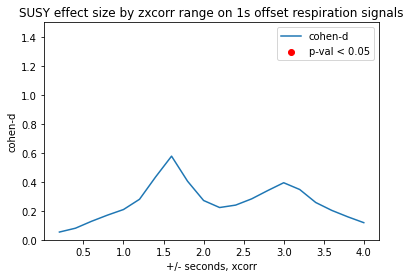

In [74]:
df_tests['cohen-d'].plot()
plt.xlabel('+/- seconds, xcorr')
plt.title('SUSY effect size by zxcorr range on 1s offset respiration signals')
plt.ylabel('cohen-d')
a = df_tests.loc[df_tests['p-val']<0.05,'cohen-d']
plt.scatter(a.index,a.values,color='r',label='p-val < 0.05')
plt.legend()
plt.ylim([0,1.5])
plt.savefig('./plots/ES_zxcorrRange_Resp_1soff.png', bbox_inches = 'tight',dpi = 300)

plt.show()

*Note on respiration phase alignement in music listeners:* In my experience, most pairs of respiration sequences to the same music would not show enough alignment to be caught by dyadic SUSY, even in repeated listenings from the same participant. Respiratory phase alignment is not so robust as to show consistently with this kind of pairwise comparison. Instead the statistical power to claim that music can influence listeners breath timing comes from aggregating phase information across tens of measurements at once, using a technique more explicitly designed to measure synchronised behaviour to music (Activity Analysis).  

Still, for this pair of respiration sequences, SUSY can capture something, at least when using parameters tuned to allow relevant information to be captured (phasic) and not erasing shared information with oscillations over the cross-correlation range. 

And for continuous responses to music, be they motion or psychophysiological, lags on the scale of 5-10 s are arguably not necessary, at least not when the interesting signal information is in response to a highly predictable musical stimulus. 

# Discussion of What SUSY is good for and how it could be improved

As I've tried to show, SUSY is good at capturing some kinds of information between pairs of signals, but not all, and it is important to understand how the parameters determine what kind of information gets counted towards this quantification of "synchrony". There is no signal-agnostic measurement of similarity or shared information for time series data, and its important to understand what is preserved and what is being thrown out by any strategy applied. 

If the interesting information between the signal pairs is changing slower than cross-correlation range, and if there aren't higher frequency components complicating the signal, there is a good chance of SUSY performing as promised. And if it is not important for the synchrony to mean anything more stringent than any offset within the cross-correlation range, calling this calculation a measure of synchrony would be fair.

However, if the signals involve higher frequency components, say oscillations that would cycle within the cross-correlation range, it is likely that this will add noise to the calculations across all segments. Specifically, it will increase the risk of FALSE NEGATIVE results. If the signals are expected to share information with less of a delay than 6 or 10 seconds, reducing the cross-correlation range might help the reliability of the assessment. 

One strategy to consider is simply replacing the cross-correlation measure with a metric of similarity that is more suitable for the signal and quality of information to be assessed for synchrony. It would still be necessary to justify how that combination of measure and signal expose relevant information, however a lot of the signals in music have sufficiently well known qualities to make informed parameter choices, and validated with toy data like I shared here. 

Given that the major problem with the average Fisher's Z transformed cross-correlation is how phasing produces both positive and negative values, some might consider instead using the averaging the absolute values of these instead. $Z_{abs}$ has been used in some applications of SUSY. While that would help in some ways, the rectifying the cross-correlation has big consequences on what gets counted as shared information. Like if applied to heart rate measurements, this measure of similarity would equate any kind of change, so that a segment with HR dropping would be more similar to a segment with HR increasing than to a segment where HR was stable. There may be some circumnstances and signals for which that would be the kind of shared information we want to be measuring, but not for most of the music related applications I have seen to date.

Whatever the solution chosen for future applications, the limitations demonstrated in the above examples should temper how SUSY is interpreted, especially for signals that involve clearly oscillatory components and for which temporal alignment may be tighter than typically found in the orginal context that motivated this method of assessment (measurements from people in dialogue). 

I'm not going to go through the published papers that use SUSY to point out which results are specifically suspect. However, I would hope the reader is now in a position to consider how, for example, measurements of respiration, heart rate, heart rate variability, and many forms of audience motion to music performances can contain oscillatory components, and make their own interpretation of published positive or negative assessments of "synchrony" with an eye to the SUSY parameters applied. 